In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import json
import os
import random
#import scanpy as sc
import simba as si
si.__version__

/srv/local/jayoung/conda/envs/jy_simba_copy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.1'

In [2]:
workdir = 'result_quantify_marker_genes_v2'
si.settings.set_workdir(workdir)

Saving results in: result_quantify_marker_genes_v2


In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

NameError: name 'sc' is not defined

In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# make plots prettier
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [104]:
adata_CG = si.read_h5ad('/data/pinello/PROJECTS/2021_01_JY_SIMBA/simba_tutorials/v1.0/result_simba_rnaseq_allgenes/adata_CG.h5ad')
adata_C = si.read_h5ad('/data/pinello/PROJECTS/2021_01_JY_SIMBA/simba_tutorials/v1.0/result_simba_rnaseq_allgenes/adata_C.h5ad')
adata_G = si.read_h5ad('/data/pinello/PROJECTS/2021_01_JY_SIMBA/simba_tutorials/v1.0/result_simba_rnaseq_allgenes/adata_G.h5ad')
adata_all = si.read_h5ad('/data/pinello/PROJECTS/2021_01_JY_SIMBA/simba_tutorials/v1.0/result_simba_rnaseq_allgenes/adata_all.h5ad')
adata_cmp = si.read_h5ad('/data/pinello/PROJECTS/2021_01_JY_SIMBA/simba_tutorials/v1.0/result_simba_rnaseq/adata_cmp_sig.h5ad')

In [109]:
sum(adata_cmp.var['gini_fdr'] < 0.05)

1543

In [10]:
adata_CG.obsm['X_umap'] = adata_C[adata_CG.obs_names,].obsm['X_umap'].copy()

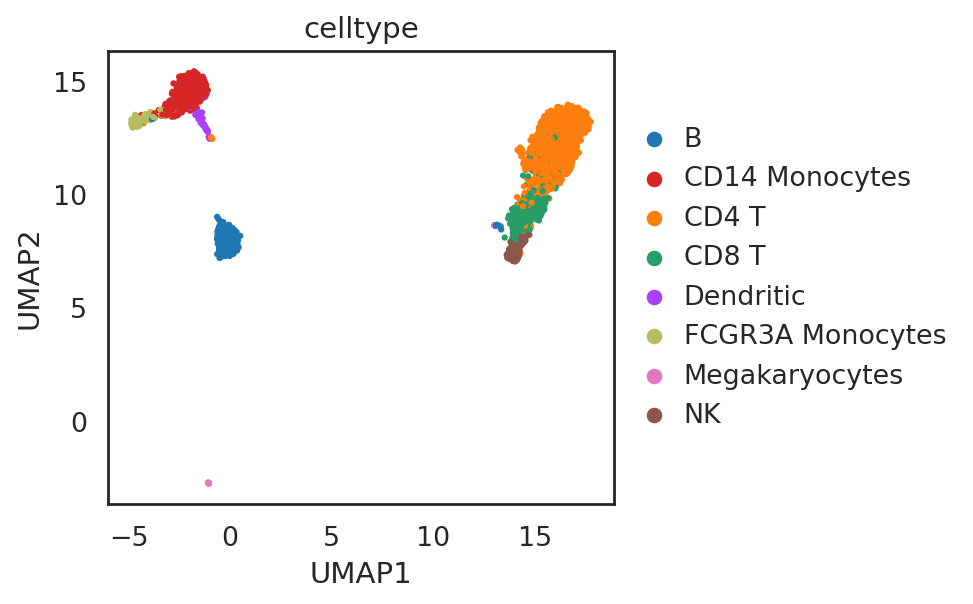

In [11]:
si.pl.umap(adata_C,color=['celltype'],
           fig_size=(6,4),
           drawing_order='random')

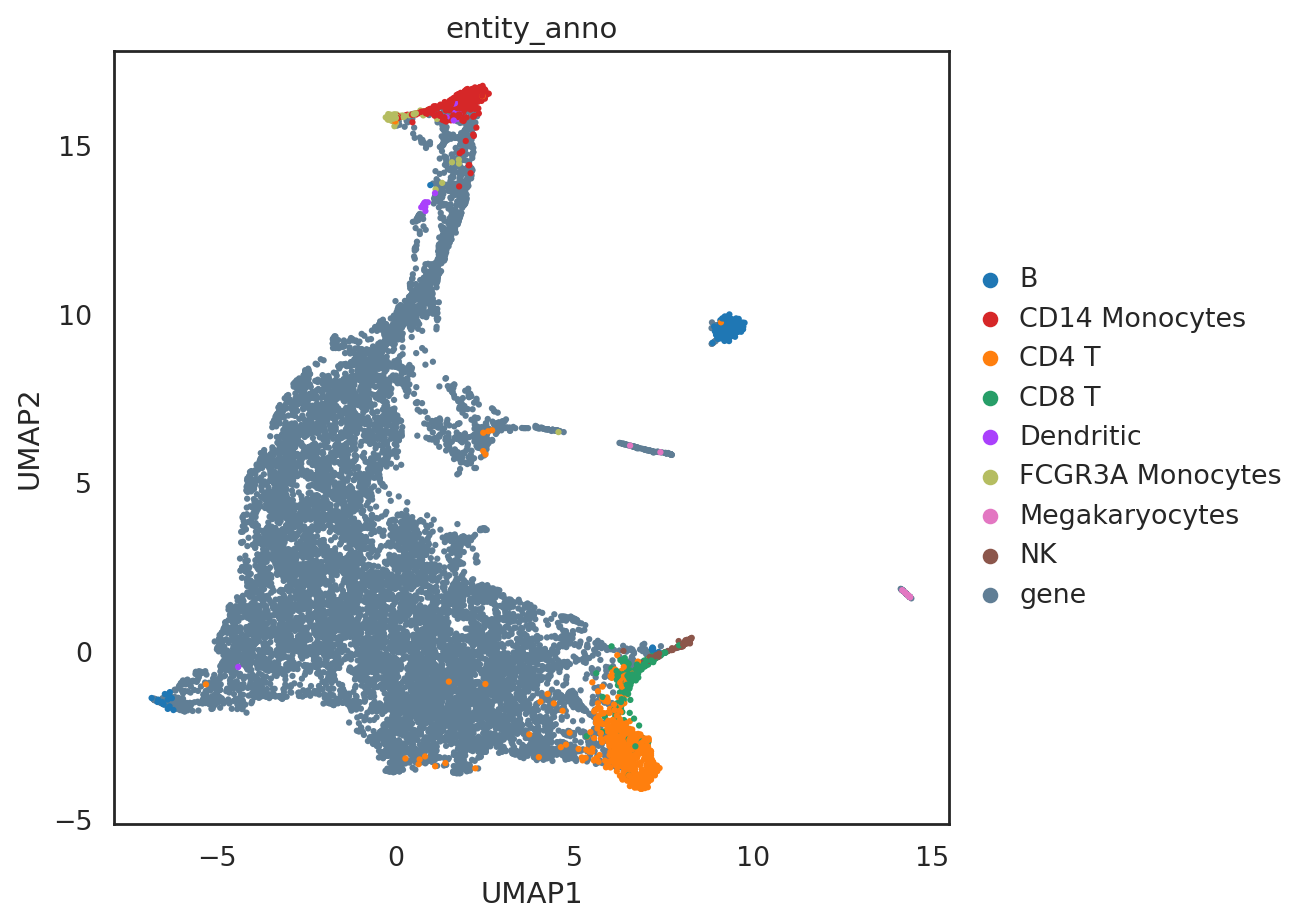

In [12]:
si.pl.umap(adata_all[::-1,],color=['entity_anno'],
           drawing_order='original',
           show_texts=False,
           fig_size=(8,6))

In [13]:
from scipy.stats import rankdata

In [14]:
features_simba = adata_cmp.var.index[
    np.argsort(rankdata(adata_cmp.var['gini'])+rankdata(adata_cmp.var['max']))][::-1][:500]
len(features_simba)

500

In [15]:
# define the cell type of each feature from the top 10 cells based on the dot product
list_celltypes = []
for x in features_simba:
    list_tmp = adata_cmp.obs.loc[adata_cmp.obs_names[adata_cmp.obs_vector(x).argsort()[-10:]], 'celltype'].tolist()
    list_celltypes.append(max(set(list_tmp), key = list_tmp.count))
np.unique(list_celltypes, return_counts=True)

(array(['B', 'CD14 Monocytes', 'CD4 T', 'CD8 T', 'FCGR3A Monocytes',
        'Megakaryocytes', 'NK'], dtype='<U16'),
 array([100, 186,  17,  10,  67,  53,  67]))

In [16]:
# choose n features from each cell type
df_dotplot = pd.DataFrame(zip(features_simba,list_celltypes), columns=['feature','celltype'])
gp = df_dotplot.groupby('celltype')
list_dotplot = []
for x in gp.groups.keys():
#     random.seed(2022)
#     list_dotplot = list_dotplot + random.sample(gp.get_group(x)['feature'].tolist(), 3)
    list_dotplot = list_dotplot + gp.get_group(x)['feature'].iloc[:3].tolist()

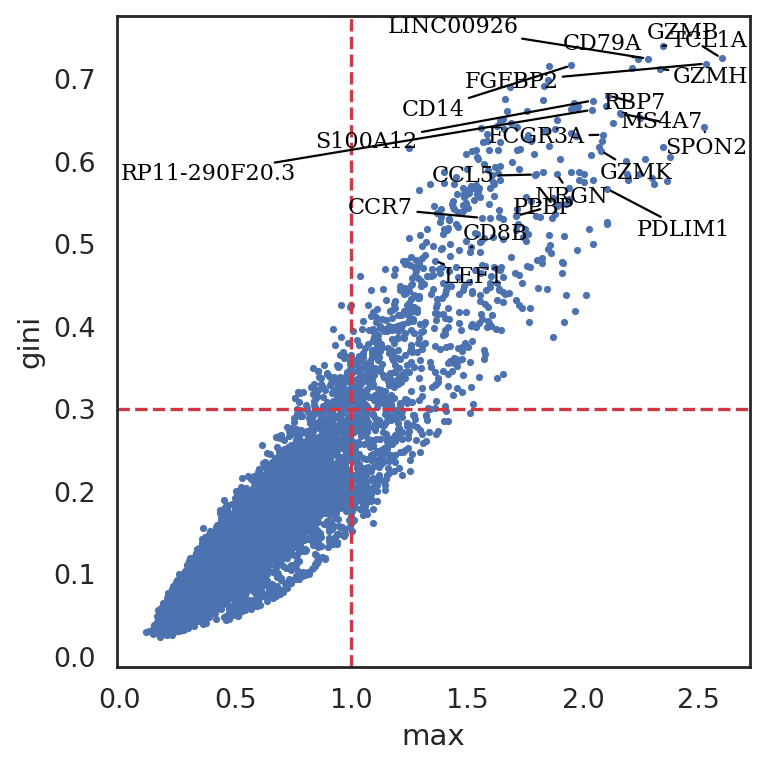

In [17]:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=list_dotplot,
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     fig_size=(5,5),
                     text_expand=(1.3,1.5),
                     cutoff_x=1.,
                     cutoff_y=0.3,
                     save_fig=False)

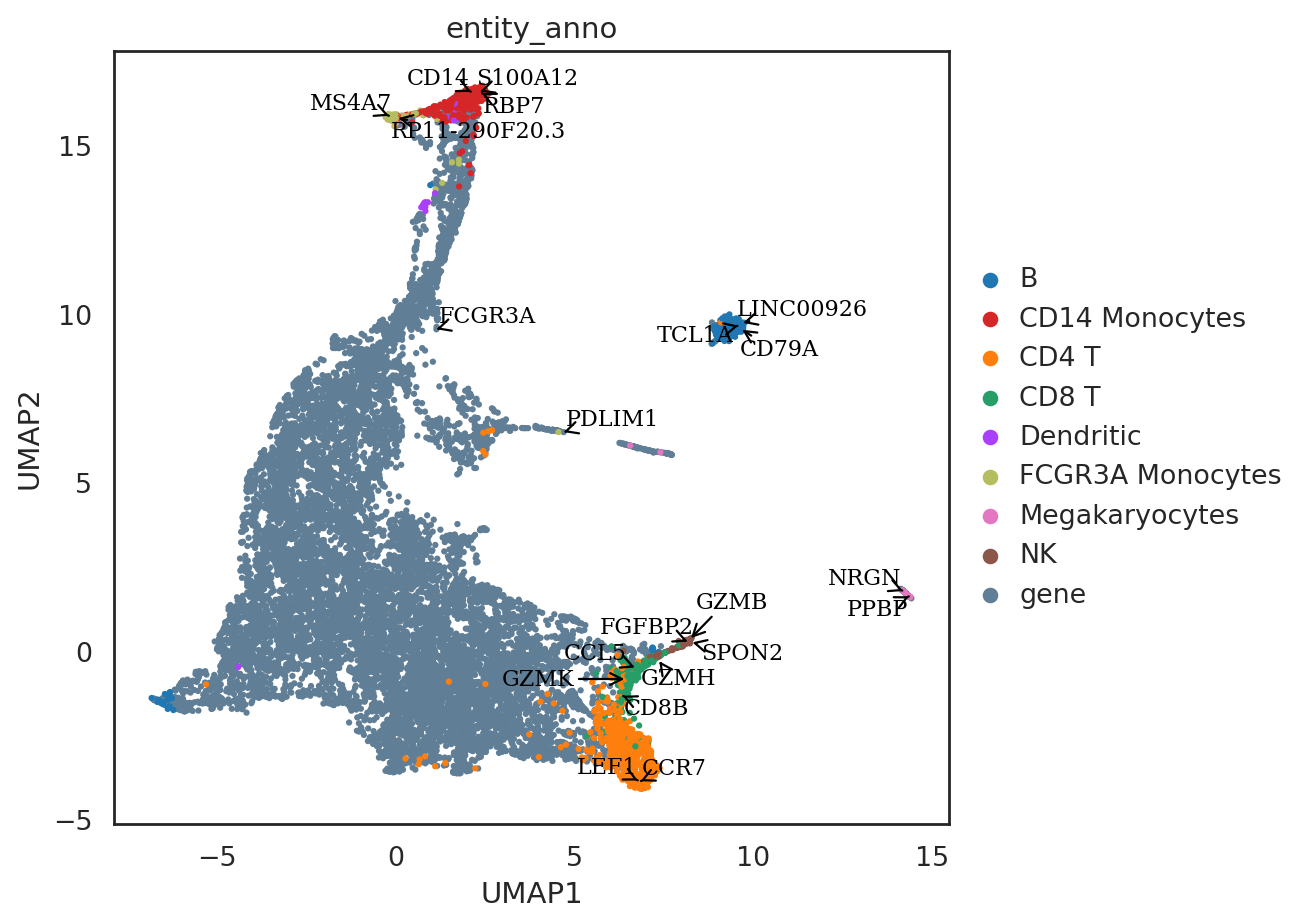

In [18]:
si.pl.umap(adata_all[::-1,],color=['entity_anno'],
           drawing_order='original',
           show_texts=True,
           texts=list_dotplot,
           fig_size=(8,6))

In [19]:
sc.pl.umap(adata_CG, color=list_dotplot, ncols=5)

NameError: name 'sc' is not defined

In [ ]:
sc.pl.dotplot(adata_CG, list_dotplot, groupby='celltype',swap_axes=True, mean_only_expressed=False,
             categories_order=gp.groups.keys());

In [20]:
def _gini(array):
    """Calculate the Gini coefficient of a numpy array.
    """

    array = array.flatten().astype(float)
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

In [21]:
df_expr = pd.DataFrame(index=adata_CG.obs_names,
             columns=adata_CG.var_names,
             data=adata_CG.X.A)
df_expr['celltype'] = adata_CG.obs['celltype']

df_expr_avg = df_expr.groupby('celltype').mean()

### Selecting 500 features


In [22]:
features_hk = ['ACTB', 'ALDOA', 'GAPDH', 'PGK1', 'LDHA', 'RPS27A', 'RPL19',
            'RPL11', 'NONO', 'ARHGDIA', 'RPL32', 'RPS18', 'C1orf43', 'CHMP2A',
            'EMC7', 'GPI', 'RAB7A', 'REEP5', 'SNRPD3', 'VCP', 'VPS29']

In [99]:
def plot_top_marker_gini(ax, n_features=500):
    features_rnd = random.sample(adata_CG.var_names.tolist(), n_features)
    features_hs = features_hs_all.iloc[np.argsort(features_hs_all['log.p.adj'], )[:n_features],:].index.tolist()
    features_simba = adata_cmp.var.index[
        np.argsort(rankdata(adata_cmp.var['gini'])+rankdata(adata_cmp.var['max']))][::-1][:n_features]
    list_gini_simba = [_gini(df_expr_avg[x].values) for x in features_simba]
    list_gini_hs = [_gini(df_expr_avg[x].values) for x in features_hs]
    list_gini_hk = [_gini(df_expr_avg[x].values) for x in features_hk]
    list_gini_rnd = [_gini(df_expr_avg[x].values) for x in features_rnd]
    df_plot_simba = pd.DataFrame(
        data=zip(list_gini_simba, ['SIMBA']*len(features_simba), features_simba),
        columns=['Gini', 'Type', 'feature'])
    df_plot_hs = pd.DataFrame(
        data=zip(list_gini_hs, ['scHaystack']*len(features_hs), features_hs),
        columns=['Gini', 'Type', 'feature'])
    df_plot_hk = pd.DataFrame(
        data=zip(list_gini_hk, ['Housekeeping']*len(features_hk), features_hk),
        columns=['Gini', 'Type', 'feature'])
    df_plot_rnd = pd.DataFrame(
        data=zip(list_gini_rnd, ['Random']*len(features_rnd), features_rnd),
        columns=['Gini', 'Type', 'feature'])

    df_plot = pd.concat([df_plot_simba, df_plot_hs, df_plot_hk, df_plot_rnd])
    # sns.set_theme(context='notebook', style="whitegrid")
    order = ['SIMBA', 'scHaystack', 'Housekeeping', 'Random']
    sns.boxplot(data=df_plot, x="Type", y="Gini", order=order, ax = ax)
    ax.locator_params(axis='y', nbins=5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f"Top {n_features} features")
    ax.plot((1), (0), ls="", marker=">", ms=10, color="k", transform=ax.transAxes, clip_on=False)
    ax.plot((0), (1), ls="", marker="^", ms=10, color="k", transform=ax.transAxes, clip_on=False)
    ax.grid(axis='y')
    pairs = [('SIMBA','Housekeeping'), ('SIMBA','scHaystack'), ('SIMBA','Random')]
    annotator = Annotator(ax, pairs, data=df_plot, x='Type', y='Gini', order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    ax.set_xticks([0, 1, 2, 3], ["SIMBA", "scHaystack", "Housekeeping", "Random"], rotation=45, ha='right')
    ax.set(xlabel=None)
    #return(df_plot)

In [98]:
ax[0,0].set_xticks([0, 1, 2, 3])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SIMBA vs. scHaystack: Mann-Whitney-Wilcoxon test two-sided, P_val:7.685e-04 U_stat=9.500e+01
SIMBA vs. Housekeeping: Mann-Whitney-Wilcoxon test two-sided, P_val:1.006e-05 U_stat=2.100e+02
SIMBA vs. Random: Mann-Whitney-Wilcoxon test two-sided, P_val:7.685e-04 U_stat=9.500e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SIMBA vs. scHaystack: Mann-Whitney-Wilcoxon test two-sided, P_val:1.521e-07 U_stat=2.012e+03
SIMBA vs. Housekeeping: Mann-Whitney-Wilcoxon test two-sided, P_val:3.893e-11 U_stat=1.050e+03
SIMBA vs. Random: Mann-Whitney-Wilcoxon test two-sided, P_val:1.124e-09 U_stat=2.134e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-0

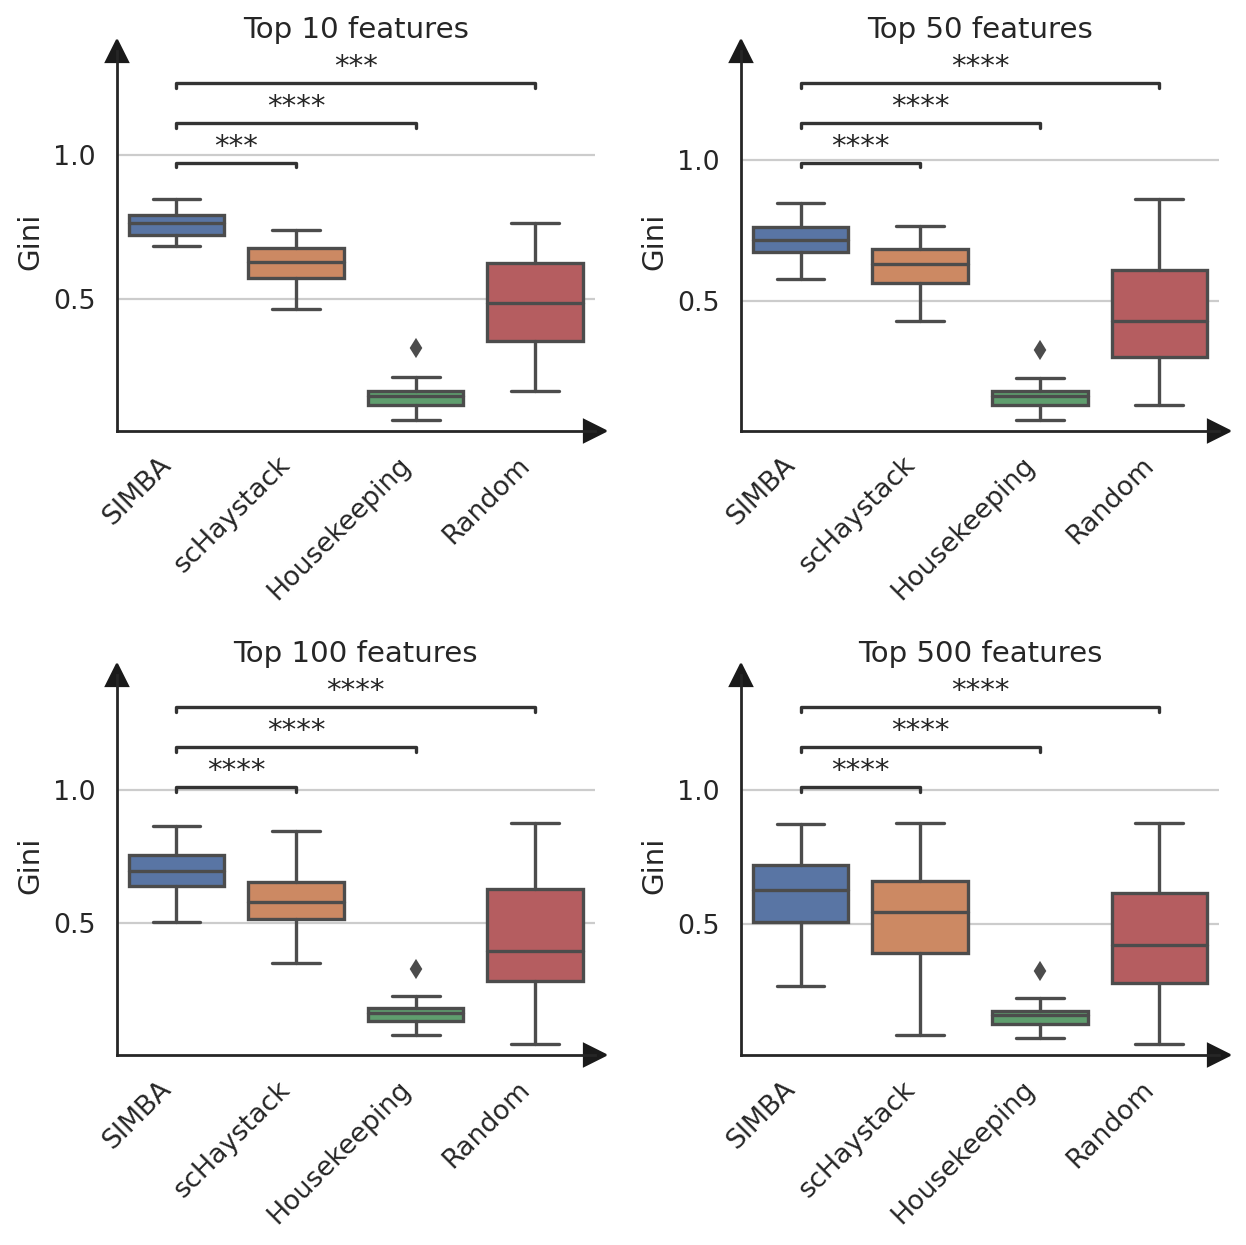

In [100]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
plot_top_marker_gini(ax[0, 0], 10)
plot_top_marker_gini(ax[0, 1], 50)
plot_top_marker_gini(ax[1, 0], 100)
plot_top_marker_gini(ax[1, 1], 500)
plt.tight_layout()
plt.savefig(f'marker_genes_gini_by_n_features_pbmc.png', dpi=300, bbox_inches='tight')

In [23]:
random.seed(2022)


In [27]:
features_hs_all = pd.read_table("scHaystack_pbmc_binary.txt", sep = " ")

In [35]:
features_hs_all.iloc[np.argsort(features_hs_all['log.p.adj'], )[:500],]

,D_KL,log.p.vals,log.p.adj,T.counts
CFD,0.042358,-69.538412,-65.401248,603
LGALS2,0.043491,-67.433022,-63.295858,564
CD68,0.040856,-67.012199,-62.875035,579
HLA-DQA1,0.040075,-66.079339,-61.942175,573
SPI1,0.040536,-65.350635,-61.213470,560
...,...,...,...,...
CARD9,0.062730,-26.564028,-22.426864,56
CHST12,0.009954,-26.548858,-22.411694,298
ITGAX,0.039181,-26.495619,-22.358455,74
TPST2,0.008729,-26.495203,-22.358038,372


In [60]:
sum(features_hs_all['log.p.adj']< np.log(0.001))

1740

In [101]:
features_hs_all


,D_KL,log.p.vals,log.p.adj,T.counts
AL627309.1,0.036500,-0.984736,0.0,9
AP006222.2,0.022234,-0.152594,0.0,3
RP11-206L10.2,0.040632,-0.498700,0.0,3
RP11-206L10.9,0.101312,-1.650546,0.0,3
LINC00115,0.008390,-0.215278,0.0,18
...,...,...,...,...
AC145212.1,0.015097,-0.514556,0.0,15
AL592183.1,0.000642,-1.136863,0.0,314
AL354822.1,0.038213,-0.923724,0.0,8
PNRC2.1,0.002890,-2.617697,0.0,106


In [41]:
list_gini_simba = [_gini(df_expr_avg[x].values) for x in features_simba]
list_gini_hs = [_gini(df_expr_avg[x].values) for x in features_hs]
list_gini_hk = [_gini(df_expr_avg[x].values) for x in features_hk]
list_gini_rnd = [_gini(df_expr_avg[x].values) for x in features_rnd]

In [48]:
pd.Series(list_gini_simba).describe()

count    500.000000
mean       0.616854
std        0.137438
min        0.270661
25%        0.507284
50%        0.626849
75%        0.721086
max        0.872218
dtype: float64

In [47]:
pd.Series(list_gini_hs).describe()

count    500.000000
mean       0.521309
std        0.178769
min        0.087189
25%        0.394700
50%        0.543752
75%        0.660624
max        0.875000
dtype: float64

In [53]:
df_plot_simba = pd.DataFrame(
    data=zip(list_gini_simba, ['SIMBA']*len(features_simba), features_simba),
    columns=['Gini', 'Type', 'feature'])
df_plot_hs = pd.DataFrame(
    data=zip(list_gini_hs, ['scHaystack']*len(features_hs), features_hs),
    columns=['Gini', 'Type', 'feature'])
df_plot_hk = pd.DataFrame(
    data=zip(list_gini_hk, ['Housekeeping']*len(features_hk), features_hk),
    columns=['Gini', 'Type', 'feature'])
df_plot_rnd = pd.DataFrame(
    data=zip(list_gini_rnd, ['Random']*len(features_rnd), features_rnd),
    columns=['Gini', 'Type', 'feature'])

df_plot = pd.concat([df_plot_simba, df_plot_hs, df_plot_hk, df_plot_rnd])

In [51]:
from statannotations.Annotator import Annotator

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SIMBA vs. scHaystack: Mann-Whitney-Wilcoxon test two-sided, P_val:3.388e-16 U_stat=1.623e+05
SIMBA vs. Housekeeping: Mann-Whitney-Wilcoxon test two-sided, P_val:8.690e-15 U_stat=1.049e+04
SIMBA vs. Random: Mann-Whitney-Wilcoxon test two-sided, P_val:1.832e-29 U_stat=1.765e+05


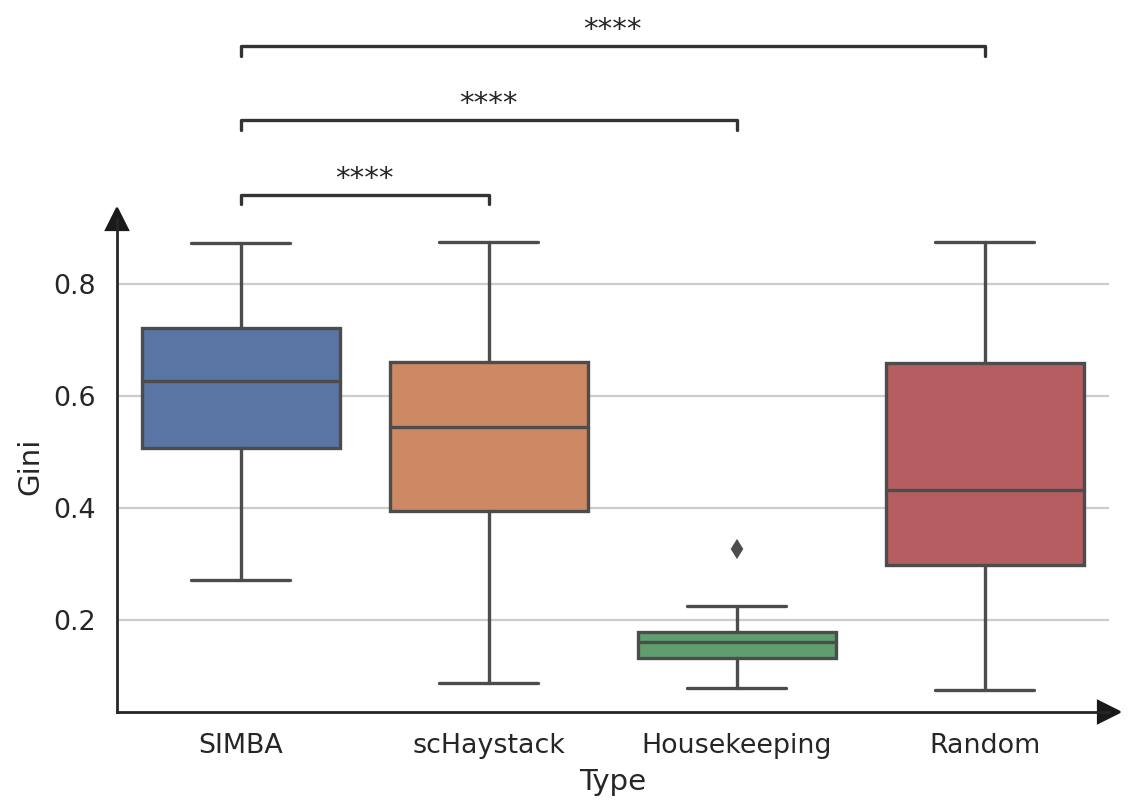

In [54]:
# sns.set_theme(context='notebook', style="whitegrid")
plt.figure(figsize=(8,4))
order = ['SIMBA', 'scHaystack', 'Housekeeping', 'Random']
ax = sns.boxplot(data=df_plot, x="Type", y="Gini", order=order)
ax.locator_params(axis='y', nbins=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot((1), (0), ls="", marker=">", ms=10, color="k", transform=ax.transAxes, clip_on=False)
ax.plot((0), (1), ls="", marker="^", ms=10, color="k", transform=ax.transAxes, clip_on=False)
plt.grid(axis='y')
pairs = [('SIMBA','Housekeeping'), ('SIMBA','scHaystack'), ('SIMBA','Random')]
annotator = Annotator(ax, pairs, data=df_plot, x='Type', y='Gini', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.savefig('marker_genes.png', dpi=300, bbox_inches='tight')

In [ ]:
adata_CG